In [4]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import json
from pprint import pprint

def save_fig(fig, name):
    fig.savefig("graphs/{}.svg".format(name), format="svg")
    fig.savefig("graphs/{}.pdf".format(name), format="pdf")

In [5]:
mandelbrot80 = []
mandelbrot32 = []
mandelbrot64 = []
simd32 = []
simd64 = []

def read_file(file):
    json_path='./data/' +file
    with open(json_path) as f:
        data = json.load(f)

    for d in data["datapoints"]:
        s = d["setting"]
        avg_time = list(map(lambda x: (x["computationTime"], x["iterationCount"], x["pixelCount"]),
                       sorted(d["data"]["workers"], key=lambda x: x["rank"])))
        #avg_time = np.average(avg_time)
        if s["implementation"] == "mandelbrot32":
            mandelbrot32.extend(avg_time)
        elif s["implementation"] == "mandelbrot":
            mandelbrot80.extend(avg_time)
        elif s["implementation"] == "mandelbrot64":
            mandelbrot64.extend(avg_time)
        if s["implementation"] == "mandelbrotsimd32":
            simd32.extend(avg_time)
        elif s["implementation"] == "mandelbrotsimd64":
            simd64.extend(avg_time)
#read_file("all_impl_all_points.json")
#read_file("all_impl_all_points.37.json")
#read_file("all_impl_all_points.37.10runs.json")
#read_file("all_impl_all_points.10.json")
#read_file("all_impl_all_points.10.5.3runs.json")
#read_file("all_impl_all_points.37.mI10000.json")
read_file("all_impl_all_points.37.mI150.json")

print(len(mandelbrot32))
print(len(mandelbrot64))
print(len(simd32))
print(len(simd64))
print(len(mandelbrot80))

720
720
720
720
0


In [6]:
#comp80, it80, pix80 = zip(*mandelbrot80)
comp32, it32, pix32 = zip(*mandelbrot32)
comp64, it64, pix64 = zip(*mandelbrot64)
compsimd32, itsimd32, pixsimd32 = zip(*simd32)
compsimd64, itsimd64, pixsimd64 = zip(*simd64)
names = ["32 bit", "64 bit", "32 bit (SIMD)", "64 bit (SIMD)", "80 bit"]

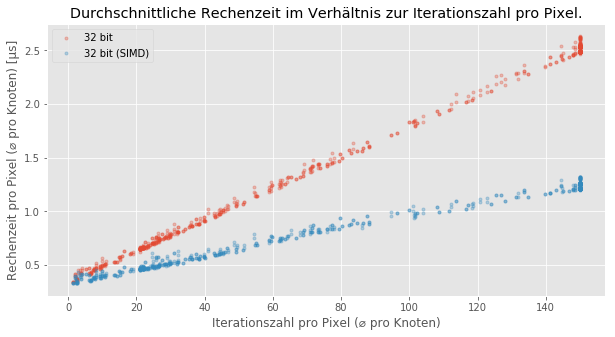

In [8]:
plt.style.use('ggplot')

fig, line = plt.subplots(1, 1, figsize=(10,5))

x32 = np.asarray(it32)/np.asarray(pix32)

cpi32 = (np.asarray(comp32)/np.asarray(pix32))
cpisimd32 = (np.asarray(compsimd32)/np.asarray(pix32))

p0 = line.plot(x32, cpi32, label=names[0], lw=0, marker=".", alpha=0.3)
p1 = line.plot(x32, cpisimd32, label=names[2], lw=0, marker=".", alpha=0.3)

line.legend()


line.set(xlabel='Iterationszahl pro Pixel (⌀ pro Knoten)', ylabel='Rechenzeit pro Pixel (⌀ pro Knoten) [µs]',
       title='Durchschnittliche Rechenzeit im Verhältnis zur Iterationszahl pro Pixel.')
line.grid(True)
#line.axis([0, None, 0, 0.04])


# TODO instead: show higher simd overhead => line fit

plt.show()
save_fig(fig, "itvscmp.32")

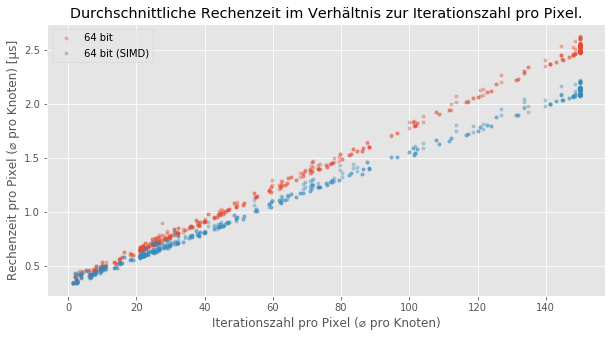

In [9]:
plt.style.use('ggplot')

fig, (line) = plt.subplots(1, 1, figsize=(10,5))

x64 = np.asarray(it64)/np.asarray(pix64)

cpi64 = (np.asarray(comp64)/np.asarray(pix64))
cpisimd64 = (np.asarray(compsimd64)/np.asarray(pix64))

p2 = line.plot(x64, cpi64, label=names[1], lw=0, marker=".", alpha=0.3)
p3 = line.plot(x64, cpisimd64, label=names[3], lw=0, marker=".", alpha=0.3)

line.legend()


line.set(xlabel='Iterationszahl pro Pixel (⌀ pro Knoten)', ylabel='Rechenzeit pro Pixel (⌀ pro Knoten) [µs]',
       title='Durchschnittliche Rechenzeit im Verhältnis zur Iterationszahl pro Pixel.')
line.grid(True)
#line.axis([0, None, 0, 0.04])


# TODO instead: show higher simd overhead => line fit

plt.show()
save_fig(fig, "itvscmp.64")

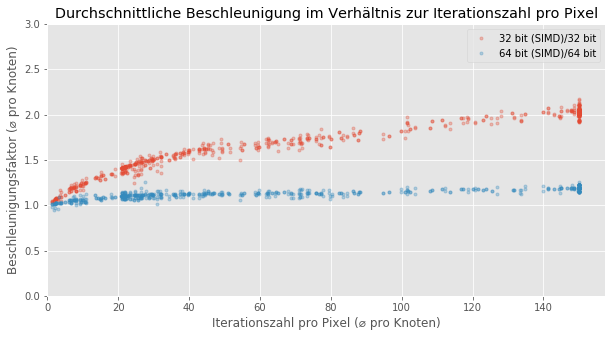

In [10]:
plt.style.use('ggplot')
# TODO this graph and the two below in one figure

fig, (line) = plt.subplots(1, 1, figsize=(10,5))
speedup32 = (np.asarray(comp32)/np.asarray(compsimd32))
speedup64 = (np.asarray(comp64)/np.asarray(compsimd64))
p0 = line.plot(np.asarray(it32)/np.asarray(pix32), speedup32, label="{}/{}".format(names[2], names[0]), lw=0, marker=".", alpha=0.3)
p1 = line.plot(np.asarray(it64)/np.asarray(pix64), speedup64, label="{}/{}".format(names[3], names[1]), lw=0, marker=".", alpha=0.3)
line.legend()

line.set(xlabel='Iterationszahl pro Pixel (⌀ pro Knoten)', ylabel='Beschleunigungsfaktor (⌀ pro Knoten)',
       title='Durchschnittliche Beschleunigung im Verhältnis zur Iterationszahl pro Pixel')
line.grid(True)
line.axis([0, None, 0, 3])

plt.show()
save_fig(fig, "speedup")

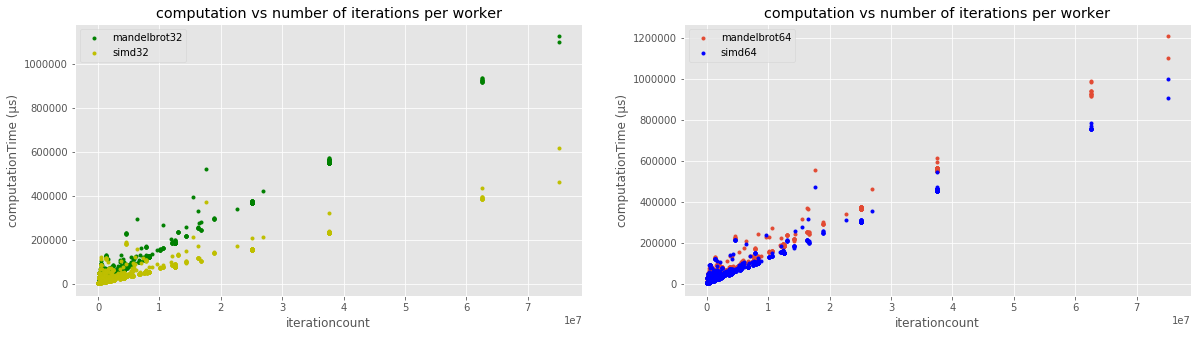

In [28]:
# Data for plotting
x = np.arange(len(simd64))

plt.style.use('ggplot')
fig, (line32, line64) = plt.subplots(1, 2, figsize=(20,5))

p0 = line32.plot(list(it32), list(comp32), label=names[0], lw=0, marker=".",color="g")
p1 = line64.plot(list(it64), list(comp64), label=names[1], lw=0, marker=".")

p2 = line32.plot(list(itsimd32), list(compsimd32), label=names[2], lw=0, marker=".",  color="y")

p3 = line64.plot(list(itsimd64), list(compsimd64), label=names[3], lw=0, marker=".",  color="b")
line32.legend()
line64.legend()

line32.set(xlabel='iterationcount', ylabel='computationTime (µs)',
       title='computation vs number of iterations per worker')
line64.set(xlabel='iterationcount', ylabel='computationTime (µs)',
       title='computation vs number of iterations per worker')
line32.grid(True)
line64.grid(True)
plt.show()


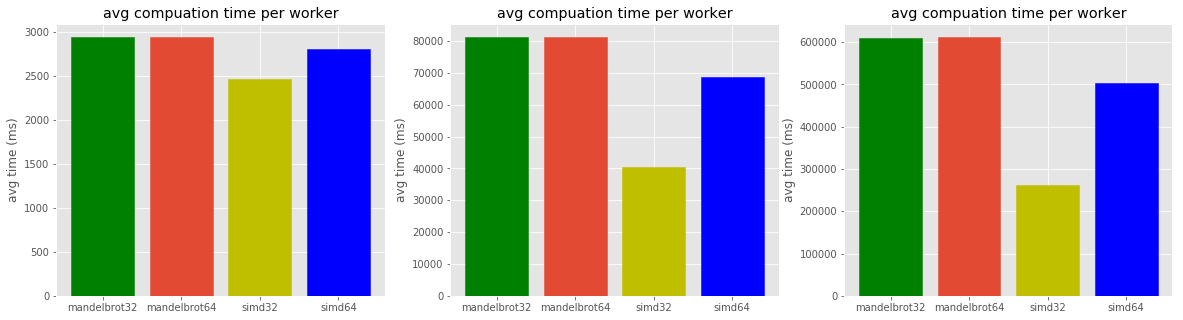

In [31]:
fig, (barworst, baravg, barbest) = plt.subplots(1, 3, figsize=(20,5))

def slicep(l, startp, endp):
    begin = int(len(l)*startp)
    end = int(len(l)*endp)
    l = sorted(l)
    return l[begin:end]

def bargraph(bar, startp, endp):
    avg = np.asarray([np.average(slicep(comp32, startp, endp)), np.average(slicep(comp64, startp, endp)), np.average(slicep(compsimd32, startp, endp)), np.average(slicep(compsimd64, startp, endp))])
    x_avg = np.arange(len(avg))

    barlist = bar.bar(x_avg, avg)
    # set colors of bars to match colors in line plot
    #TODO this bar graph 3 times: worst 25%, average 50%, best 25%
    barlist[0].set_color(p0[0].get_color())
    barlist[1].set_color(p1[0].get_color())
    barlist[2].set_color(p2[0].get_color())
    barlist[3].set_color(p3[0].get_color())

    bar.set_xticks(x_avg)
    bar.set_xticklabels(names)
    bar.set(ylabel="avg time (ms)",
           title="avg compuation time per worker")
    bar.grid(True)

bargraph(barworst, 0, .05)
bargraph(baravg, .05, .95)
bargraph(barbest, .95, 1)
# fig.savefig("impl_test.svg", format="svg")
plt.show()

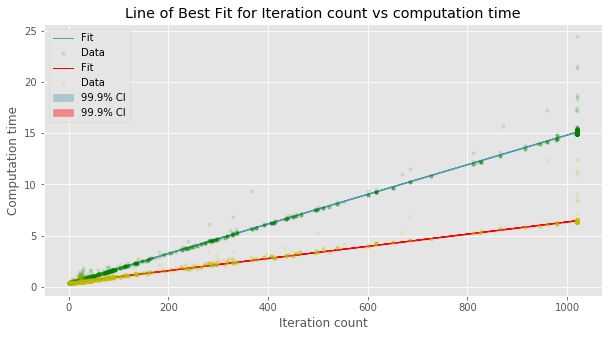

In [106]:
# Perform linear regression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
import pandas as pd
import math

def draw_log_log(implementation, ax, fit_color, points_color):

    compsorted, itsorted, pix = zip(*sorted(implementation, key=lambda x: x[1]))
    #pix = [math.log10(x) for x in pix]
    #compsorted = [math.log10(x) - pix[i] for i,x in enumerate(compsorted)]
    #itsorted = [math.log10(x) - pix[i] for i,x in enumerate(itsorted)]
    compsorted = [x / pix[i] for i,x in enumerate(compsorted)]
    itsorted = [x / pix[i] for i,x in enumerate(itsorted)]

    x = sm.add_constant(itsorted)
    y = compsorted
    regr = sm.OLS(y, x)
    res = regr.fit()
    # Get fitted values from model to plot
    st, data, ss2 = summary_table(res, alpha=0.01)
    fitted_values = data[:,2]

    # Get the confidence intervals of the model
    predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T

    # Data for regions where we want to shade to indicate the intervals has
    # to be sorted by the x axis to display correctly
    CI_df = pd.DataFrame(columns = ['x_data', 'low_CI', 'upper_CI'])
    CI_df['x_data'] = itsorted
    CI_df['low_CI'] = predict_mean_ci_low
    CI_df['upper_CI'] = predict_mean_ci_upp
    CI_df.sort_values('x_data', inplace = True)

    # Define a function for the line plot with intervals
    def lineplotCI(x_data, y_data, sorted_x, low_CI, upper_CI, x_label, y_label, title):
        # Create the plot object

        # Plot the data, set the linewidth, color and transparency of the
        # line, provide a label for the legend
        ax.plot(x_data, y_data, lw = 1, color = fit_color, alpha = 1, label = 'Fit')
        # Shade the confidence interval
        ax.fill_between(sorted_x, low_CI, upper_CI, color = fit_color, alpha = 0.4, label = '99.9% CI')
        ax.plot(x_data, compsorted, lw=0, color = points_color, alpha = 0.1, label = 'Data', marker='.')
        # Label the axes and provide a title
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        #plt.yscale('log')
        #plt.xscale('log')
        # Display legend
        ax.legend(loc = 'best')
        return ax

    # Call the function to create plot
    ax = lineplotCI(x_data = itsorted
               , y_data = fitted_values
               , sorted_x = CI_df['x_data']
               , low_CI = CI_df['low_CI']
               , upper_CI = CI_df['upper_CI']
               , x_label = 'Iteration count'
               , y_label = 'Computation time'
               , title = 'Line of Best Fit for Iteration count vs computation time')

_, ax = plt.subplots(figsize=(10, 5))
draw_log_log(mandelbrot32, ax, '#539caf', 'g')
draw_log_log(simd32, ax, 'r', 'y')
